In [2]:
import numpy as np
import os

np.random.seed(42)

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGE_PATH = os.path.join(PROJECT_ROOT_DIR,"images",CHAPTER_ID)

def save_fig(fig_id,tight_layout=True,fig_extension="png",resolution =300 ):
    path = os.path.join(IMAGE_PATH,fig_id+"."+fig_extension)
    print("Saving figure",fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path,format=fig_extension,dpi = resolution)
        

In [3]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url= HOUSING_URL,housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path,"housing.tgz")
    urllib.request.urlretrieve(housing_url,tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()


# Uncomment next cell to update Dataset from original Databse

In [4]:
#fetch_housing_data()

In [5]:
import pandas as pd

def load_housing_data(housing_path = HOUSING_PATH):
    csv_path = os.path.join(housing_path,"housing.csv")
    return pd.read_csv(csv_path)

In [6]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [7]:
housing["income_cat"] = np.ceil(housing["median_income"]/1.5)
housing["income_cat"].where(housing["income_cat"] < 5, 5.0,inplace=True)

In [8]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=42)
for train_index,test_index in split.split(housing,housing["income_cat"]):    
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]   


In [9]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [10]:
housing_labels = strat_train_set["median_house_value"].copy()
housing = strat_train_set.drop("median_house_value",axis=1)
housing_num = housing.drop('ocean_proximity',axis =1)
housing_cat = housing['ocean_proximity']

In [11]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from scipy import sparse

class CategoricalEncoder(BaseEstimator, TransformerMixin):
    """Encode categorical features as a numeric array.
    The input to this transformer should be a matrix of integers or strings,
    denoting the values taken on by categorical (discrete) features.
    The features can be encoded using a one-hot aka one-of-K scheme
    (``encoding='onehot'``, the default) or converted to ordinal integers
    (``encoding='ordinal'``).
    This encoding is needed for feeding categorical data to many scikit-learn
    estimators, notably linear models and SVMs with the standard kernels.
    Read more in the :ref:`User Guide <preprocessing_categorical_features>`.
    Parameters
    ----------
    encoding : str, 'onehot', 'onehot-dense' or 'ordinal'
        The type of encoding to use (default is 'onehot'):
        - 'onehot': encode the features using a one-hot aka one-of-K scheme
          (or also called 'dummy' encoding). This creates a binary column for
          each category and returns a sparse matrix.
        - 'onehot-dense': the same as 'onehot' but returns a dense array
          instead of a sparse matrix.
        - 'ordinal': encode the features as ordinal integers. This results in
          a single column of integers (0 to n_categories - 1) per feature.
    categories : 'auto' or a list of lists/arrays of values.
        Categories (unique values) per feature:
        - 'auto' : Determine categories automatically from the training data.
        - list : ``categories[i]`` holds the categories expected in the ith
          column. The passed categories are sorted before encoding the data
          (used categories can be found in the ``categories_`` attribute).
    dtype : number type, default np.float64
        Desired dtype of output.
    handle_unknown : 'error' (default) or 'ignore'
        Whether to raise an error or ignore if a unknown categorical feature is
        present during transform (default is to raise). When this is parameter
        is set to 'ignore' and an unknown category is encountered during
        transform, the resulting one-hot encoded columns for this feature
        will be all zeros.
        Ignoring unknown categories is not supported for
        ``encoding='ordinal'``.
    Attributes
    ----------
    categories_ : list of arrays
        The categories of each feature determined during fitting. When
        categories were specified manually, this holds the sorted categories
        (in order corresponding with output of `transform`).
    Examples
    --------
    Given a dataset with three features and two samples, we let the encoder
    find the maximum value per feature and transform the data to a binary
    one-hot encoding.
    >>> from sklearn.preprocessing import CategoricalEncoder
    >>> enc = CategoricalEncoder(handle_unknown='ignore')
    >>> enc.fit([[0, 0, 3], [1, 1, 0], [0, 2, 1], [1, 0, 2]])
    ... # doctest: +ELLIPSIS
    CategoricalEncoder(categories='auto', dtype=<... 'numpy.float64'>,
              encoding='onehot', handle_unknown='ignore')
    >>> enc.transform([[0, 1, 1], [1, 0, 4]]).toarray()
    array([[ 1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.],
           [ 0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])
    See also
    --------
    sklearn.preprocessing.OneHotEncoder : performs a one-hot encoding of
      integer ordinal features. The ``OneHotEncoder assumes`` that input
      features take on values in the range ``[0, max(feature)]`` instead of
      using the unique values.
    sklearn.feature_extraction.DictVectorizer : performs a one-hot encoding of
      dictionary items (also handles string-valued features).
    sklearn.feature_extraction.FeatureHasher : performs an approximate one-hot
      encoding of dictionary items or strings.
    """

    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):
        """Fit the CategoricalEncoder to X.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_feature]
            The data to determine the categories of each feature.
        Returns
        -------
        self
        """

        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")

        X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(np.sort(self.categories[i]))

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self

    def transform(self, X):
        """Transform X using one-hot encoding.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data to encode.
        Returns
        -------
        X_out : sparse matrix or a 2-d array
            Transformed input.
        """
        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            valid_mask = np.in1d(X[:, i], self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    # Set the problematic rows to an acceptable value and
                    # continue `The rows are marked `X_mask` and will be
                    # removed later.
                    X_mask[:, i] = valid_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)

        column_indices = (X_int + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csc_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out

## Attribute Adder Function

In [12]:
from sklearn.base import BaseEstimator, TransformerMixin

# column index
longitude_ix,latitude_ix,rooms_ix, bedrooms_ix, population_ix, household_ix = 0,1,3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True,add_sqr_location=True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
        self.add_sqr_location = add_sqr_location
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        longitude_sqr= X[:, longitude_ix] * X[:, longitude_ix]
        latitude_sqr= X[:, latitude_ix] * X[:, latitude_ix]
        long_lat=X[:, longitude_ix] *X[:, latitude_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            if self.add_sqr_location:
                return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room,longitude_sqr,latitude_sqr,long_lat]
            else: 
                 return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]   
        else:
            if self.add_sqr_location:
                return np.c_[X, rooms_per_household, population_per_household,longitude_sqr,latitude_sqr,long_lat]
            else:
                return np.c_[X, rooms_per_household, population_per_household]


In [13]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

# Pipeline defination

In [91]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', Imputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder(add_bedrooms_per_room=True,add_sqr_location=True)),
        ('std_scaler', StandardScaler()),
    ])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('cat_encoder', CategoricalEncoder(encoding="onehot-dense")),
    ])

In [113]:
from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

# Linear Regresion

#### Making Data

In [114]:
housing_prepared = full_pipeline.fit_transform(housing)

In [115]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

### Testing

In [116]:
test_prepared= full_pipeline.fit_transform(strat_test_set.drop("median_house_value",axis=1))
test_labels =strat_test_set["median_house_value"].copy()

In [117]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(test_prepared)
lin_mse = mean_squared_error(test_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

66477.842003472935

In [118]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(test_labels, housing_predictions)
lin_mae

48420.724913010352

In [119]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(test_labels,housing_predictions)

28.491088597271698

# Random Forest

## Testing range of estimatores

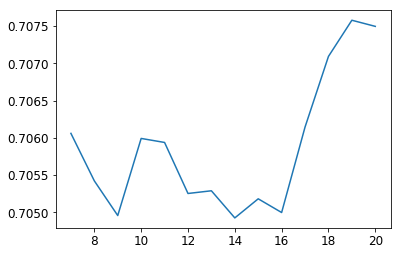

In [120]:
from sklearn.ensemble import RandomForestRegressor
estimators = np.arange(7,21,1)
score=[]
for n in estimators:
    regr = RandomForestRegressor(max_depth =5,n_estimators =n,random_state= 42)
    regr.fit(housing_prepared, housing_labels)
    score.append(regr.score(housing_prepared, housing_labels))
plt.plot(estimators,score)

## Testing different min_impurity_decrease

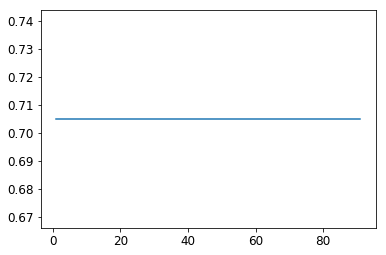

In [121]:
from sklearn.ensemble import RandomForestRegressor
estimators = np.arange(1,100,10)
score=[]
for n in estimators:
    regr = RandomForestRegressor(max_depth =5,n_estimators =9,random_state= 42,min_impurity_decrease = n)
    regr.fit(housing_prepared, housing_labels)
    score.append(regr.score(housing_prepared, housing_labels))
plt.plot(estimators,score)

## Testing

In [122]:
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(max_depth =5,n_estimators =19,random_state= 42,min_impurity_decrease =20.0)
regr.fit(housing_prepared, housing_labels)
regr.feature_importances_

array([  2.17685797e-03,   1.94407005e-03,   2.87163567e-02,
         1.10027630e-03,   1.08726519e-03,   2.40490601e-04,
         3.99942205e-03,   6.41741773e-01,   1.12033642e-03,
         1.06113003e-01,   9.72706988e-04,   6.65485175e-04,
         3.45443995e-03,   3.90924451e-03,   0.00000000e+00,
         2.02758272e-01,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00])

In [123]:
housing_predictions = regr.predict(test_prepared)
Ran_mse = mean_squared_error(test_labels, housing_predictions)
Ran_rmse = np.sqrt(Ran_mse)
Ran_rmse

68109.796622696784

In [124]:
from sklearn.metrics import mean_absolute_error

Ran_mae = mean_absolute_error(test_labels, housing_predictions)
Ran_mae

50216.732502097249

In [125]:
mean_absolute_percentage_error(test_labels,housing_predictions)

30.398209073822901

# Gradient boosting Regressor

## Testing range of values of max features

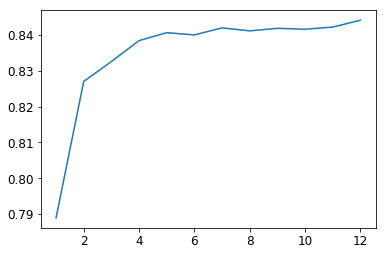

In [126]:
from sklearn.ensemble import GradientBoostingRegressor
estimators = np.arange(1,13,1)
score=[]
for n in estimators:
    regr = GradientBoostingRegressor(n_estimators=100, max_depth=4,learning_rate=0.1, min_samples_leaf=5,max_features=n)
    regr.fit(housing_prepared, housing_labels)
    score.append(regr.score(housing_prepared, housing_labels))
plt.plot(estimators,score)

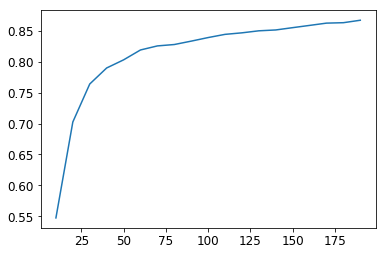

In [127]:
from sklearn.ensemble import GradientBoostingRegressor
estimators = np.arange(10,200,10)
score=[]
for n in estimators:
    regr = GradientBoostingRegressor(n_estimators=n, max_depth=4,learning_rate=0.1, min_samples_leaf=5,max_features=5)
    regr.fit(housing_prepared, housing_labels)
    score.append(regr.score(housing_prepared, housing_labels))
plt.plot(estimators,score)

## Testing

In [153]:
regr = GradientBoostingRegressor(n_estimators=100, max_depth=4,learning_rate=0.1, min_samples_leaf=5,max_features=5)
regr.fit(housing_prepared, housing_labels)
regr.feature_importances_

array([ 0.08676841,  0.07647205,  0.06750556,  0.0189989 ,  0.0166492 ,
        0.01862538,  0.01279412,  0.15195823,  0.05734377,  0.08791694,
        0.05540931,  0.09020264,  0.08448042,  0.10686153,  0.00433443,
        0.04099431,  0.        ,  0.01094146,  0.01174334])

In [154]:
housing_predictions = regr.predict(test_prepared)
print (regr.score(test_prepared,test_labels))
Ran_mse = mean_squared_error(test_labels, housing_predictions)
Ran_rmse = np.sqrt(Ran_mse)
Ran_rmse

0.701722759276


62346.149337755647

In [152]:
mean_absolute_percentage_error(test_labels,housing_predictions)

27.265667521854521

# Neural Network

In [131]:
from sklearn.neural_network import MLPRegressor

regr = MLPRegressor(hidden_layer_sizes=(1,),  activation='identity', solver='adam',    alpha=0.001,batch_size='auto',
               learning_rate='constant', learning_rate_init=0.01, power_t=0.5, max_iter=1000, shuffle=True,
               random_state=9, tol=0.0001, verbose=False, warm_start=False, momentum=0.9,
               nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999,
               epsilon=1e-08)
regr.fit(housing_prepared, housing_labels)

MLPRegressor(activation='identity', alpha=0.001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(1,), learning_rate='constant',
       learning_rate_init=0.01, max_iter=1000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=9, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [132]:
housing_predictions = regr.predict(test_prepared)
print (regr.score(test_prepared,test_labels))
print (regr.score(housing_prepared, housing_labels))
Ran_mse = mean_squared_error(test_labels, housing_predictions)
Ran_rmse = np.sqrt(Ran_mse)
Ran_rmse

0.652139126452


67329.031695919068

In [133]:
mean_absolute_percentage_error(test_labels,housing_predictions)

29.387016670249572

## Ridge Regressions with inbuilt Cross Validation

In [50]:
from sklearn.linear_model import RidgeCV
ridge_regr = RidgeCV(alphas=(0.01,0.03,0.1,0.3,1.0,3.0, 10.0))
model_cv = ridge_regr.fit(housing_prepared, housing_labels)

In [51]:
model_cv.alpha_

0.01

In [52]:
housing_predictions = ridge_regr.predict(test_prepared)
print (ridge_regr.score(housing_prepared, housing_labels))
print (ridge_regr.score(test_prepared,test_labels))
Ridge_regr_mse = mean_squared_error(test_labels, housing_predictions)
Ridge_regr_rmse = np.sqrt(Ridge_regr_mse)
Ridge_regr_rmse

0.655258225673
0.661185608198


66447.783966142961

In [53]:
mean_absolute_percentage_error(test_labels,housing_predictions)

28.492943239526074